<a href="https://colab.research.google.com/github/harjeet88/stock-prediction/blob/main/grok/stock_trader_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6705f9023a9b5c799cc6c66be8aa5abce6389bb9864d6be354ff53d8bc4bb351
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator
from scipy.signal import find_peaks
import datetime


In [4]:
# Define the stock ticker and date range
ticker = "AAPL"  # Change to any stock ticker
start_date = "2023-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [5]:
# Fetch stock data
stock = yf.Ticker(ticker)
df = stock.history(start=start_date, end=end_date)

In [7]:
# Fundamental Analysis
info = stock.info
fundamentals = {
    "Company": info.get("longName", "N/A"),
    "Sector": info.get("sector", "N/A"),
    "P/E Ratio": info.get("trailingPE", "N/A"),
    "EPS": info.get("trailingEps", "N/A"),
    "Dividend Yield": info.get("dividendYield", "N/A"),
    "Market Cap": info.get("marketCap", "N/A"),
    "52 Week High": info.get("fiftyTwoWeekHigh", "N/A"),
    "52 Week Low": info.get("fiftyTwoWeekLow", "N/A")
}


print("\nFundamental Analysis for", ticker)
for key, value in fundamentals.items():
    print(f"{key}: {value}")


Fundamental Analysis for AAPL
Company: Apple Inc.
Sector: Technology
P/E Ratio: 31.346813
EPS: 6.43
Dividend Yield: 0.52
Market Cap: 3010459860992
52 Week High: 260.1
52 Week Low: 169.21


In [8]:
# Technical Indicators
# MACD
macd = MACD(df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_Hist"] = macd.macd_diff()

In [9]:
# RSI
rsi = RSIIndicator(df["Close"], window=14)
df["RSI"] = rsi.rsi()

In [10]:
# Supertrend (Custom Implementation)
def supertrend(df, period=10, multiplier=3):
    hl2 = (df["High"] + df["Low"]) / 2
    atr = (df["High"] - df["Low"]).rolling(window=period).mean()
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    supertrend = pd.Series(index=df.index, dtype=float)
    trend = pd.Series(index=df.index, dtype=bool)

    for i in range(1, len(df)):
        if df["Close"].iloc[i-1] > supertrend.iloc[i-1]:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True  # Uptrend
        else:
            supertrend.iloc[i] = upperband.iloc[i]
            trend.iloc[i] = False  # Downtrend
        if i == 1:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True

    return supertrend, trend

In [11]:
df["Supertrend"], df["Trend"] = supertrend(df)

In [12]:
# Elliott Wave (Simplified Peak/Trough Detection)
def detect_elliott_wave(df, prominence=0.05):
    prices = df["Close"].values
    # Find peaks and troughs
    peaks, _ = find_peaks(prices, prominence=prominence * prices.mean())
    troughs, _ = find_peaks(-prices, prominence=prominence * prices.mean())
    return peaks, troughs

peaks, troughs = detect_elliott_wave(df)

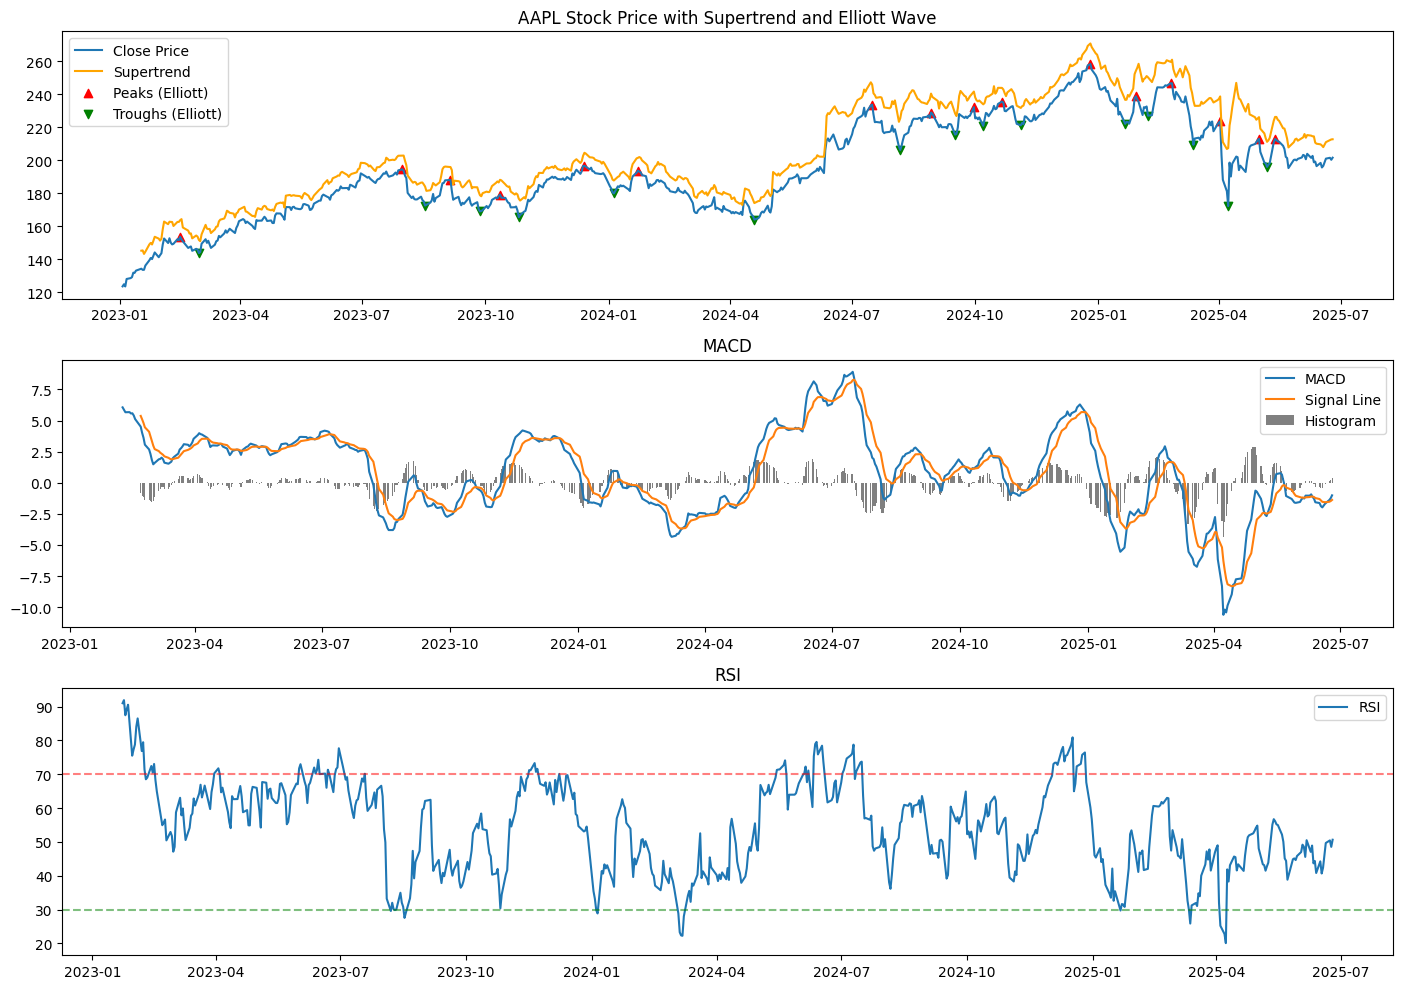

In [13]:
# Plotting
plt.figure(figsize=(14, 10))

# Price and Supertrend
plt.subplot(3, 1, 1)
plt.plot(df.index, df["Close"], label="Close Price")
plt.plot(df.index, df["Supertrend"], label="Supertrend", color="orange")
plt.scatter(df.index[peaks], df["Close"].iloc[peaks], color="red", marker="^", label="Peaks (Elliott)")
plt.scatter(df.index[troughs], df["Close"].iloc[troughs], color="green", marker="v", label="Troughs (Elliott)")
plt.title(f"{ticker} Stock Price with Supertrend and Elliott Wave")
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["MACD_Signal"], label="Signal Line")
plt.bar(df.index, df["MACD_Hist"], label="Histogram", color="gray")
plt.title("MACD")
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(df.index, df["RSI"], label="RSI")
plt.axhline(70, color="red", linestyle="--", alpha=0.5)
plt.axhline(30, color="green", linestyle="--", alpha=0.5)
plt.title("RSI")
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# Print latest indicator values
print("\nLatest Technical Indicator Values:")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}, Signal: {df['MACD_Signal'].iloc[-1]:.2f}, Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Supertrend: {df['Supertrend'].iloc[-1]:.2f}, Trend: {'Up' if df['Trend'].iloc[-1] else 'Down'}")


Latest Technical Indicator Values:
MACD: -1.01, Signal: -1.38, Histogram: 0.37
RSI: 50.64
Supertrend: 212.75, Trend: Down


In [15]:
# Print latest indicator values and trade signals
print("\nLatest Technical Indicator Values:")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}, Signal: {df['MACD_Signal'].iloc[-1]:.2f}, Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Supertrend: {df['Supertrend'].iloc[-1]:.2f}, Trend: {'Up' if df['Trend'].iloc[-1] else 'Down'}")



Latest Technical Indicator Values:
MACD: -1.01, Signal: -1.38, Histogram: 0.37
RSI: 50.64
Supertrend: 212.75, Trend: Down
